# Model

Identification model uses a convoluted neural network from Keras libraray, with an input size of (40,40,1) and an output size of 1 using sigmoid as activation function. It includes 3 Conv2D layers with activation of relu, 2 MaxPooling2D layers, 1 Flatten layer and 3 Dropout layers. 

Pictures input should be preprocessed. They are at gray scale, and are done thresholding so that they contain only two unique pixels: 0 or 255.  

For status, output 0 indicates no headstand and output 1 indicates headstand. After 15-epoch training, the model achieves an accuracy of 98.96% for training and 99.68% for validation. When applied on the real verification codes, its answers are totally correct on 10 codes.

In [1]:
from Tools import *    

In [2]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import load_model
from keras import optimizers
from PIL import Image, ImageFont, ImageDraw

Using TensorFlow backend.


Load all samples we generated before.

In [17]:
Xs = np.load("Xs.npy")
ys = np.load("ys.npy")
Xr = np.load("Xr.npy")
yr = np.load("yr.npy")

Build the batch generator

In [18]:
batch_size_tr = 128
batch_size_ts = 64
train_datagen = ImageDataGenerator(rescale=1./255,
                           #featurewise_center=True,
                           #featurewise_std_normalization=True,
                           shear_range=0.2,
                           zoom_range=0.2,
                           #preprocessing_function=preprocess_input,
                           horizontal_flip=True)
train_datagen.fit(Xr)
train_generator = train_datagen.flow(
                        Xr,yr,
                        batch_size=batch_size_tr,
                        )
        
test_datagen = ImageDataGenerator(rescale=1./255,
                           #featurewise_center=True,
                           #featurewise_std_normalization=True,
                           shear_range=0.2,
                           zoom_range=0.2,
                           #preprocessing_function=preprocess_input,
                           horizontal_flip=True)
test_datagen.fit(Xs)
test_generator = test_datagen.flow(
                        Xs,ys,
                        batch_size=batch_size_tr,
                        )

Test the batch generator
This code is cited and modified from https://github.com/sdrangan/introml/blob/master/cnn/lab08_fine_tune_partial.ipynb

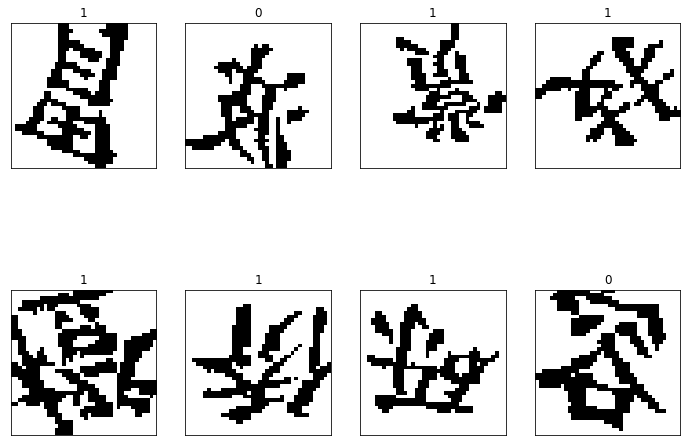

In [14]:
# display the data
X_mini,y_mini = train_generator.next()
plt.figure(figsize=(12, 9))
for i, (img, label) in enumerate(list(zip(X_mini, y_mini))[:8]):
    plt.subplot(2, 4, i+1)
    plt.title(str(int(label)))
    disp_image(Image.fromarray(np.uint8(img.squeeze()*255),mode='L').convert('RGB'))

## Build the CNN model
Model arguments are refered to https://keras.io/layers/core/
Some slight adjustments are made until a good result is obtained

In [18]:
K.clear_session()
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(40, 40, 1)))
model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
#####################above is model establishing##################
########ready for training########


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
__________

In [19]:
opt = optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt,
      loss='binary_crossentropy',
      metrics=['accuracy'])
steps_per_epoch = train_generator.n // batch_size_tr
validation_steps = test_generator.n // batch_size_ts
nepochs = 15

In [20]:
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/15
1024/1024 [==============================] - 37s 36ms/step - loss: 0.2778 - acc: 0.8710 - val_loss: 0.1038 - val_acc: 0.9634
Epoch 2/15
1024/1024 [==============================] - 36s 35ms/step - loss: 0.1241 - acc: 0.9518 - val_loss: 0.0763 - val_acc: 0.9741
Epoch 3/15
1024/1024 [==============================] - 36s 35ms/step - loss: 0.0929 - acc: 0.9648 - val_loss: 0.0528 - val_acc: 0.9827
Epoch 4/15
1024/1024 [==============================] - 36s 35ms/step - loss: 0.0759 - acc: 0.9716 - val_loss: 0.0467 - val_acc: 0.9827
Epoch 5/15
1024/1024 [==============================] - 36s 35ms/step - loss: 0.0637 - acc: 0.9770 - val_loss: 0.0346 - val_acc: 0.9883
Epoch 6/15
1024/1024 [==============================] - 36s 35ms/step - loss: 0.0549 - acc: 0.9798 - val_loss: 0.0277 - val_acc: 0.9905
Epoch 7/15
1024/1024 [==============================] - 35s 35ms/step - loss: 0.0477 - acc: 0.9830 - val_loss: 0.0243 - val_acc: 0.9937
Epoch 8/15
1024/1024 [==========================

save our trained model

In [22]:
model.save('model1.h5')

In [12]:
model = load_model('model1.h5')

## Prediction on real verification codes

We use our trained model to predict the answer on 10 real verification codes.
The reliable answers are made by human beings. They are:
1), "捎","慈","琴","漆","氓","吕","奥", with \[0,0,0,1,0,0,1\]
2), "肝","球","止","粗","锉","说","曼", with \[1,0,0,0,0,0,1\]
3), "彬","眶","落","氨","肋","能","智", with \[1,0,1,0,0,0,0\]
4), "女","具","堆","价","散","合","胁", with \[0,0,0,0,1,0,0\]
5), "调","尖","伍","冬","绒","啊","碱", with \[0,1,0,0,0,0,0\]
6), "剑","铭","恩","残","囤","肛","若", with \[0,1,0,0,1,0,0\]
7), "毯","押","库","爱","忌","火","伊", with \[0,1,0,1,0,0,0\]
8), "爽","靖","女","借","竞","塑","氮", with \[0,0,0,1,0,0,1\]
9), "探","守","焚","唤","浊","辱","汽", with \[0,0,1,0,0,0,0\]
10),"闪","坎","躯","黑","侄","虾","拙", with \[1,0,0,1,0,0,0\]

We can see that our model answered complete correctly on all codes.

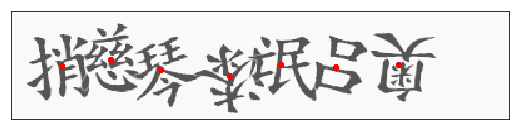

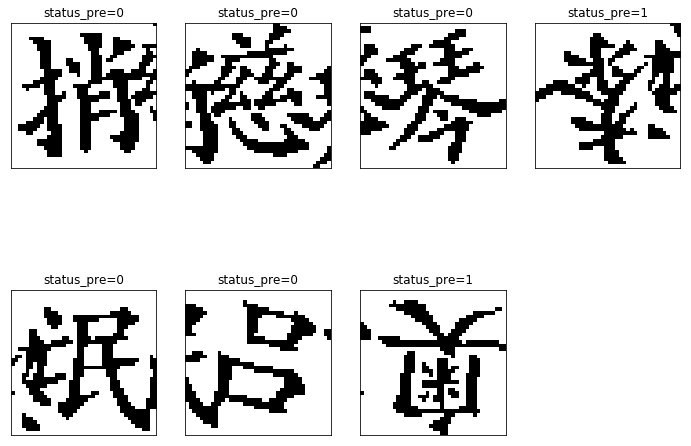

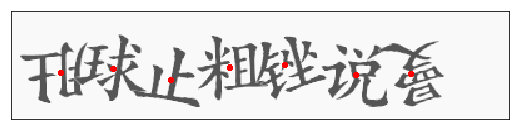

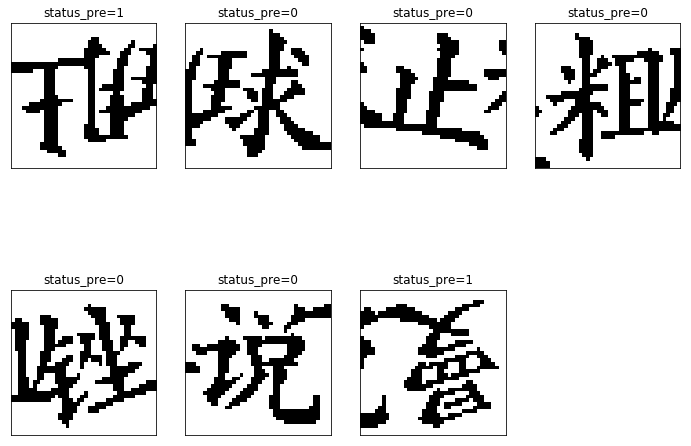

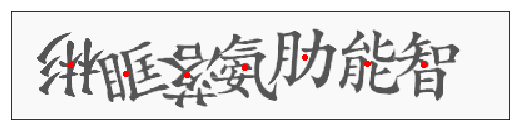

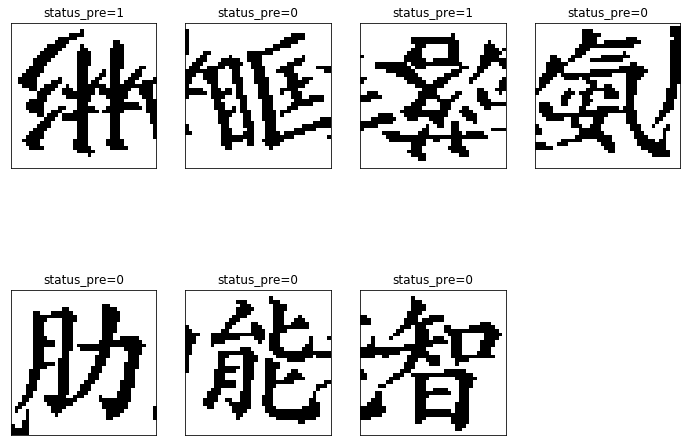

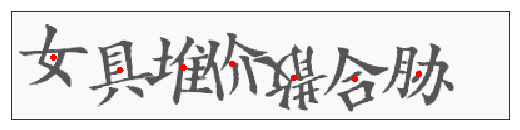

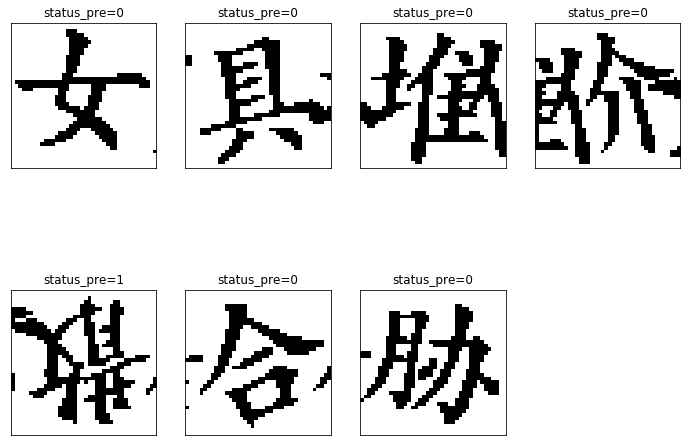

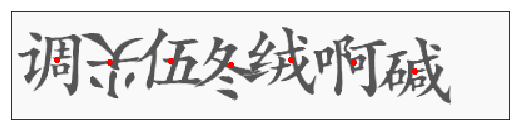

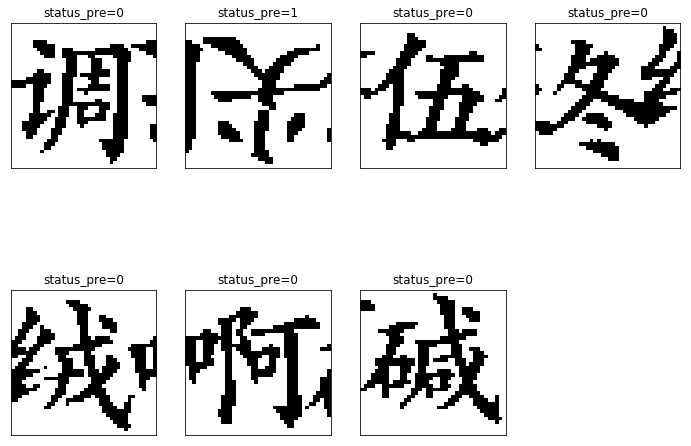

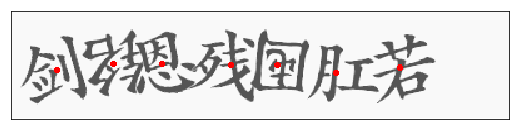

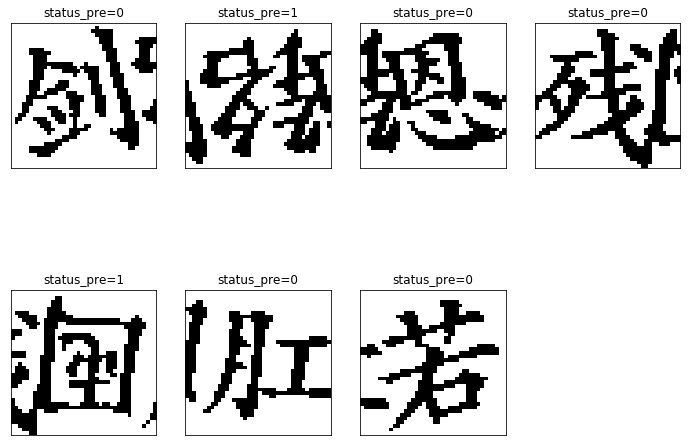

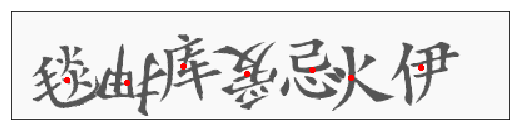

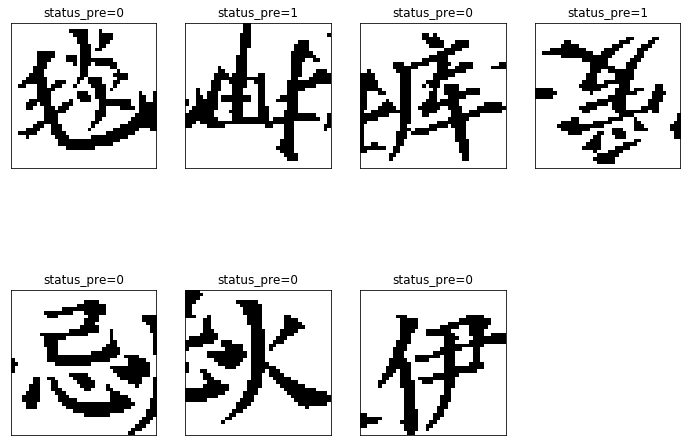

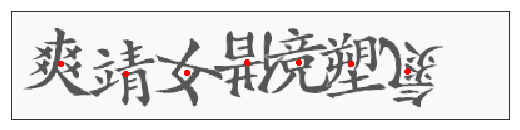

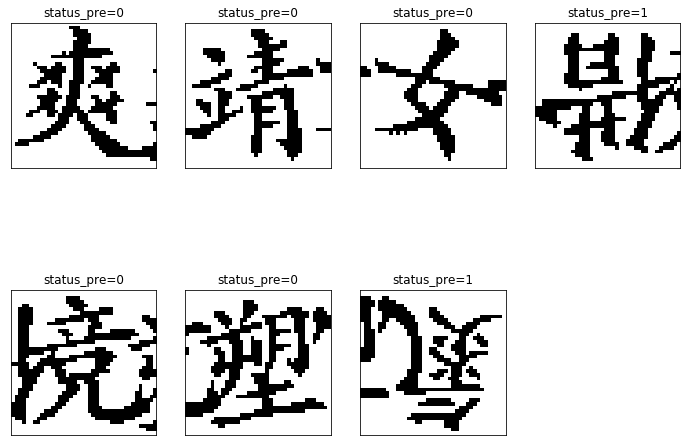

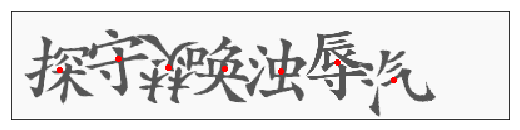

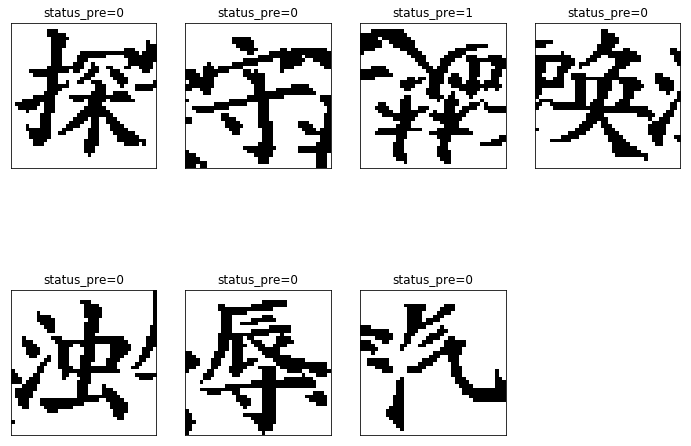

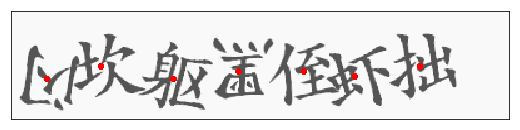

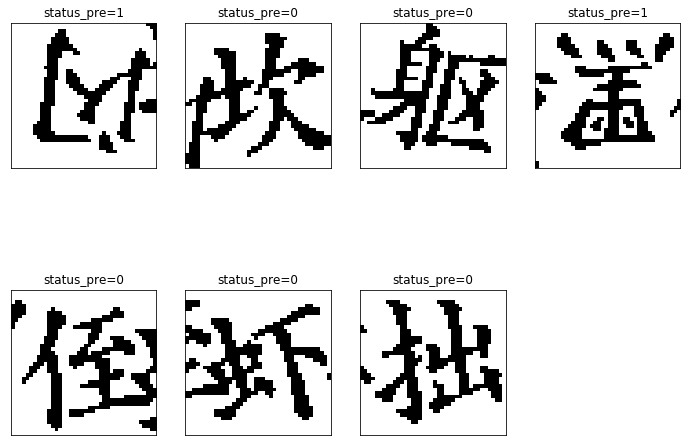

In [15]:
#predict

for i in range(10):
    im = Image.open('./captcha/captcha00'+str(i)+'.gif') 
    X = scissor(im)
    yhat = np.zeros(7)
    for i in range(7):
        X[i][None,:,:,None]
        yhat[i] = (model.predict(X[i][None,:,:,None]))
    PrintSingle(X,yhat)